# Experiment 3: Impact of open world

We want to see how well a classifier trained on a dataset with few sources performs on/generalizes to a dataset with more sources. This simulates the real world experience where models will be trained with a limited number of sources, but exposed to more and unfamiliar sources when processing data from the internet.

To do the experiment, we compare the peformance of a closed set classifier (trained and tested on the same sources) to an open set classifier, which experiences unfamiliar sources at test time.  In other words, this assessing is the effects of **dataset shift**.

To peform this, we'll train one set of models using all 30 sources and test on a test set with all 30 sources (closed world).  For comparison, we'll also train models on half of the sources, then test on all 30 sources, half of which are unfamiliar (open world). Both sets of models are tested on the same test sets. We can compare the performance difference between model pairs to measure performance decline due to open set generalization.  Which 15 sources are included in training is random, so we repeat each experiment 5X to quantify uncertainty.

We only include the QM features.  We focus on the Naive Bayes model.

In [1]:
%matplotlib widget
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import subprocess
import random
import pickle
import numpy as np
import pandas as pd

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
# from tqdm.autonotebook import tqdm
from tqdm.notebook import tqdm

import uncertainties

from image_compression_attribution.common.code.models import quant_matrices, compr_levels
from image_compression_attribution.common.code.summarize_quant_matrices import summarize_compression_features

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 500)
pd.set_option('display.max_colwidth', 500)

from sklearn.metrics import make_scorer, roc_curve
from scipy.optimize import brentq
from scipy.interpolate import interp1d

#WARNING: this method does not seem to work well when there are large gaps
#in the ROC curve. Hence, only use this if you have interpolated between
#ROC curve data points to fill in the roc curve on a grid with small intervals.
#https://github.com/scikit-learn/scikit-learn/issues/15247#issuecomment-542138349
def calculate_eer(fpr, tpr):
    '''
    Returns the equal error rate for a binary classifier output.
    '''
    eer = brentq(lambda x : 1. - x - interp1d(fpr, tpr)(x), 0., 1.)
    return eer
  
#---------------------------------------------------------------
#Code to combine mean value and uncertainty estimate into
#one formatted string, like 3.14 +/- .02 becomes "3.14(2)"

import string

class ShorthandFormatter(string.Formatter):
  """https://pythonhosted.org/uncertainties/user_guide.html"""

  def format_field(self, value, format_spec):
    if isinstance(value, uncertainties.UFloat):
      return value.format(format_spec+'S')  # Shorthand option added
    # Special formatting for other types can be added here (floats, etc.)
    else:
      # Usual formatting:
      return super(ShorthandFormatter, self).format_field(
        value, format_spec)

def uncertainty_format_arrays(mean_vals, uncertainty_vals):
  frmtr_uncertainty = ShorthandFormatter()
  
  vals_formatted = []
  for mean, uncert in zip(mean_vals, uncertainty_vals):
    number = uncertainties.ufloat(mean, uncert)
    str_formatted = frmtr_uncertainty.format("{0:.1u}", number)
    vals_formatted.append(str_formatted)
  return vals_formatted

/app/image_compression_attribution/common/code/summarize_quant_matrices.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm  #works in notebooks or scripts


In [3]:
RND_SEED=1234
np.random.seed(RND_SEED)

In [4]:
SUMMARY_FILE = "/app/dataset/data.csv"

RESULTS_FOLDER = "results/exp_03"
os.makedirs(RESULTS_FOLDER, exist_ok=True)

df = pd.read_csv(SUMMARY_FILE)
df['timestamp'] = pd.to_datetime(df['timestamp'], utc=True)

#Drop non-image files, e.g. html files returned
#due to download errors

df, df_dropped = df[ df['mime'].str.startswith('image') ].reset_index(drop=True), \
  df[ ~df['mime'].str.startswith('image') ].reset_index(drop=True)

sources = sorted(list(df['source'].unique()))

# Experiment

In [5]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import IsolationForest
#Guide to LabelEncoder:  
#https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html


#create numerical class labels for quantization categorical names (suitable for 
#use as  ML training feature vector)
le_qs = preprocessing.LabelEncoder()
le_qs.fit(df['q_name'])
df['q_name_class'] = le_qs.transform(df['q_name'])

sources = sorted(list(df['source'].unique()))
le_sources = preprocessing.LabelEncoder()
le_sources.fit(sources)
df['source_class'] = le_sources.transform(df['source'])

In [6]:
df

,articleUrl,articleHash,imageUrl,source,mime,compression,q_hash,q_name,timestamp,q_name_class,source_class
0,https://www.abc.net.au/news/2020-05-25/toowoomba-unemployment-hits-horrific-level/12282346,4de7b04b17622bc838468486216f9878,https://live-production.wcms.abc-cdn.net.au/10d55dfa1fef3ec5f4f20cdac0b64df5?impolicy=wcms_crop_resize&cropH=528&cropW=938&xPos=1&yPos=0&width=862&height=485,abc.net.au,image/webp,92,NaN,webp_092,2020-05-25 00:00:00+00:00,254,0
1,https://www.abc.net.au/news/2017-01-11/trade-war-between-us-and-china-a-major-threat-to-australia/8172562,99770eadd0f12e1c63df525a8c739f8c,https://live-production.wcms.abc-cdn.net.au/bcbaa4880d63e1b7c46ac95773583381?impolicy=wcms_crop_resize&cropH=1037&cropW=1851&xPos=0&yPos=0&width=862&height=485,abc.net.au,image/webp,92,NaN,webp_092,2017-01-11 00:00:00+00:00,254,0
2,https://www.abc.net.au/news/2021-01-31/trainee-guide-dogs-go-for-test-runs-with-handlers/13107128,90c0fcf3f9dd12d2770ac4092ca9f612,https://live-production.wcms.abc-cdn.net.au/28314158cc17db94d2062a7539d49fd9?impolicy=wcms_crop_resize&cropH=1515&cropW=2272&xPos=0&yPos=0&width=862&height=575,abc.net.au,image/webp,92,NaN,webp_092,2021-01-31 00:00:00+00:00,254,0
3,https://www.abc.net.au/news/2021-01-31/trainee-guide-dogs-go-for-test-runs-with-handlers/13107128,90c0fcf3f9dd12d2770ac4092ca9f612,https://live-production.wcms.abc-cdn.net.au/be7013fd935ad10ecd612700c2973c9b?impolicy=wcms_crop_resize&cropH=2250&cropW=2250&xPos=375&yPos=0&width=862&height=862,abc.net.au,image/webp,92,NaN,webp_092,2021-01-31 00:00:00+00:00,254,0
4,https://www.abc.net.au/news/2021-01-31/trainee-guide-dogs-go-for-test-runs-with-handlers/13107128,90c0fcf3f9dd12d2770ac4092ca9f612,https://live-production.wcms.abc-cdn.net.au/b639a168ddb98a55e2c46628278f6063?impolicy=wcms_crop_resize&cropH=2001&cropW=3000&xPos=0&yPos=0&width=862&height=575,abc.net.au,image/webp,92,NaN,webp_092,2021-01-31 00:00:00+00:00,254,0
...,...,...,...,...,...,...,...,...,...,...,...
64680,https://www.voanews.com/usa/police-ohio-city-pledge-thorough-probe-black-teens-shooting,59bf6d29b76b4ecb4f52770f5d0f83db350da788309498666ca0a9ebfcb6bcb5,https://im-media.voltron.voanews.com/Drupal/01live-166/styles/892x501/s3/2019-04/DC772857-F881-4A9E-B36A-B693023E9514.jpg,voanews,image/jpeg,50,48c9be01d998be93be725587386b3028,jpeg_050_48c9b,2016-09-15 18:20:00+00:00,13,29
64681,https://www.voanews.com/usa/police-ohio-city-pledge-thorough-probe-black-teens-shooting,59bf6d29b76b4ecb4f52770f5d0f83db350da788309498666ca0a9ebfcb6bcb5,https://im-media.voltron.voanews.com/Drupal/01live-166/styles/sourced_737px_wide/s3/2019-04/48F9FC10-1A1C-4D52-949E-93D7CA7AEF2A.png?itok=DnRzA_-G,voanews,image/webp,92,NaN,webp_092,2016-09-15 18:20:00+00:00,254,29
64682,https://www.voanews.com/usa/police-ohio-city-pledge-thorough-probe-black-teens-shooting,59bf6d29b76b4ecb4f52770f5d0f83db350da788309498666ca0a9ebfcb6bcb5,https://im-media.voltron.voanews.com/Drupal/01live-166/styles/sourced_737px_wide/s3/2019-04/48F9FC10-1A1C-4D52-949E-93D7CA7AEF2A.png,voanews,image/webp,92,NaN,webp_092,2016-09-15 18:20:00+00:00,254,29
64683,https://www.voanews.com/usa/text-trump-kim-summit-agreement,a211274edc80df58940fa8d981593dcede819f348f3056f247303b03019f20b0,https://im-media.voltron.voanews.com/Drupal/01live-166/styles/892x501/s3/2019-04/42E315BD-BBDD-4C79-BB40-387CAB29E6AB.jpg?itok=xnZSXjXB,voanews,image/jpeg,50,48c9be01d998be93be725587386b3028,jpeg_050_48c9b,2018-06-12 04:55:00+00:00,13,29


Process:
1. Test set: contains samples from all sources.
    1. select e.g. 40% of articles from a claimed source. 
    1. Select equal # of articles from all other sources.
1. Training data:
    1. For both train sets, keep all of the remaining data from the source (60% of source), which is NOT included in the test set.
    1. For the small dataset, also: keep all remaing articles (not in the test set) from 1/2 of the remaining sources. Randomly sample 1/2 the sources.
    1. For the large dataset, randomly sample an equal number of images from all of the remaining sources. This ensures both test sets are roughly the same size.
Note: the big and small train sets are the same size, but the small train set has 1/2 the number of sources as the big train set.


Train 2 classifiers (one on the small train set, one on the large train set.) Compare them both on the test set.

In [7]:
#Prepare Train and Test Split.
#Do random sampling to make train/test split. 
#Stratify on classes = news sources.
PERCENT_TEST = 0.40

#in small set, keep this fraction of remaining sources
PERCENT_SOURCES_TO_KEEP_IN_SMALLSET = .5

all_q_name_vals = sorted(df['q_name'].unique())

#Sample from articles (so we can keep images from articles grouped together)
df_articles = df[['articleHash', 'source', 'source_class']].drop_duplicates()

NUM_TRIALS = 5
results_per_trial_qm_big = {}
results_per_trial_qm_small = {}

for trial in tqdm(range(NUM_TRIALS)):

  numsamples_balanced_testset=[]
  AUCs_qm_big = []
  AUCs_qm_small = []

  results_qm_big={}
  results_qm_small={}

  for source in sources:
    #source = sources[0]
    remaining_sources = [x for x in sources if x!=source]

    #-----------------------------------
    #Form test set:

    #get all articles from the source,
    df_articles_from_source = df_articles[df_articles['source']==source]
    df_articles_not_from_source = df_articles[df_articles['source']!=source]

    #Randomly sample articles to build test set, e.g. 40% of articles from the source:
    num_test_articles_from_source = int(PERCENT_TEST*len(df_articles_from_source))
    df_test_articles_from_source = df_articles_from_source.sample(num_test_articles_from_source)
    #then sample equal number of articles not from the source, but from ALL remaining sources
    df_test_articles_not_from_source = df_articles_not_from_source.sample(num_test_articles_from_source)
    df_test_articles = pd.concat([df_test_articles_from_source, df_test_articles_not_from_source])

    #------------------------------------
    #Form training set: keep all remaining samples from the source:

    #whatever is left is available for training
    df_train_articles_all = df_articles[ ~df_articles['articleHash'].isin(df_test_articles['articleHash'])]

    df_train_articles_from_source = df_train_articles_all[df_train_articles_all['source']==source]
    num_train_articles_from_source = len(df_train_articles_from_source)

    #------------------
    #Make 2 train sets of articles not from the source:

    #1st make a smaller training set with e.g. 50% of the sources

    num_remaining_sources_to_keep_small = int(PERCENT_SOURCES_TO_KEEP_IN_SMALLSET * len(remaining_sources))
    #get a list of e.g. 50% of the remaining sources, to keep in a small train set
    sample_remaining_sources = list(pd.Series(remaining_sources).sample(num_remaining_sources_to_keep_small))

    #keep all articles from those sources
    df_train_articles_not_from_source_small = df_train_articles_all[df_train_articles_all['source'].isin(sample_remaining_sources)]

    #-------
    #also make similarly-sized training set with all sources.

    num_train_articles_not_from_source = len(df_train_articles_not_from_source_small)

    #large train set: randomly sample equal # of articles from all remaining sources:
    df_train_articles_not_from_source_big = df_train_articles_all[df_train_articles_all['source']!=source].sample(num_train_articles_not_from_source)

    #---------
    #Combine train sets with and without the source:

    df_train_articles_small = pd.concat([df_train_articles_from_source, df_train_articles_not_from_source_small])
    df_train_articles_big   = pd.concat([df_train_articles_from_source, df_train_articles_not_from_source_big])

    assert len(df_train_articles_small)==len(df_train_articles_big)
    assert len(df_train_articles_small['source'].unique())<=len(df_train_articles_big['source'].unique())

    #------------------

    #Get all images articles in train/test splits:
    df_test = df[ df['articleHash'].isin(df_test_articles['articleHash']) ].reset_index()
    #Set ground truth label: 1 if image misattributed, else 0
    df_test['is_misattributed'] = np.array(df_test['source']!=source, dtype=int)

    df_train_small = df[ df['articleHash'].isin(df_train_articles_small['articleHash']) ].reset_index()
    df_train_big   = df[ df['articleHash'].isin(df_train_articles_big['articleHash']) ].reset_index()

    sources_train_small = sorted(df_train_small['source'].unique())
    sources_train_big = sorted(df_train_big['source'].unique())

    #-----------------------------------
    #Fit models

    #quantization matrices

    #Train model on fraction of sources
    qm_model_small = quant_matrices.attribution_quant_matrices()
    qm_model_small.fit(df_train_small[['source', 'q_name']], compr_category_names=all_q_name_vals)

    #Train model on all sources
    qm_model_big = quant_matrices.attribution_quant_matrices()
    qm_model_big.fit(df_train_big[['source', 'q_name']], compr_category_names=all_q_name_vals)

    #-----------------------------------
    #prediction on test set
    claimed_source_list = [source]*len(df_test)

    LLRs_isfake_qm_small, probs_fromsource_qm_small, probs_notfromsource_qm_small, \
      unrecognized_sources_qm_small = qm_model_small.predict(df_test['q_name'], claimed_source_list)
    df_test['LLR_qm_small'] = LLRs_isfake_qm_small
    #Determine if prediction is wrong
    misclassified_qm_small = (df_test['is_misattributed'] - .5) * LLRs_isfake_qm_small < 0
    df_test['misclassified_qm_small'] = misclassified_qm_small

    LLRs_isfake_qm_big, probs_fromsource_qm_big, probs_notfromsource_qm_big, \
      unrecognized_sources_qm_big = qm_model_big.predict(df_test['q_name'], claimed_source_list)
    df_test['LLR_qm_big'] = LLRs_isfake_qm_big
    #Determine if prediction is wrong
    misclassified_qm_big = (df_test['is_misattributed'] - .5) * LLRs_isfake_qm_big < 0
    df_test['misclassified_qm_big'] = misclassified_qm_big

    #-----------------------------------
    #Use hypothesis test score to compute ROC curve for this source:

    numsamples_balanced_testset.append(len(df_test))

    fpr, tpr, thresholds = roc_curve(df_test['is_misattributed'], df_test['LLR_qm_big'], pos_label=1)
    roc_auc = auc(fpr, tpr)
    AUCs_qm_big.append(roc_auc)

    results_qm_big[source] = {'source': source, 'fpr': fpr, 'tpr':tpr, 
                       'auc':roc_auc, 'numsamples':len(df_test),
                       'scores_isfake': df_test['LLR_qm_big'],
                       'label_isfake': df_test['is_misattributed'],
                       'df_test':df_test,
                       'num_train_sources':len(df_train_big['source'].unique()),
                       'num_test_sources':len(df_test['source'].unique())}
    results_per_trial_qm_big[trial] = results_qm_big

    #-----------
    fpr, tpr, thresholds = roc_curve(df_test['is_misattributed'], df_test['LLR_qm_small'], pos_label=1)
    roc_auc = auc(fpr, tpr)
    AUCs_qm_small.append(roc_auc)

    results_qm_small[source] = {'source': source, 'fpr': fpr, 'tpr':tpr, 
                       'auc':roc_auc, 'numsamples':len(df_test),
                       'scores_isfake': df_test['LLR_qm_small'],
                       'label_isfake': df_test['is_misattributed'],
                       'df_test':df_test,
                       'num_train_sources':len(df_train_small['source'].unique()),
                       'num_test_sources':len(df_test['source'].unique())}
    results_per_trial_qm_small[trial] = results_qm_small


  0%|          | 0/5 [00:00<?, ?it/s]

In [8]:
df_train_articles_from_source.shape

(117, 3)

In [9]:
df_train_articles_not_from_source_small.shape

(14955, 3)

## Note:
The number of sources in training and test sets is not necessarily fixed, because random sampling is done.

Ideally, for the **big num sources** set, there would be all sources (30) present in both training and test set.
But this is not always the case. The exceptions are most common where the total number of samples is small.
Then, in the test set, which is smaller than the train set (40%, not 60%), it's common to have fewer than 30 sources.

Ideally, for the **small num sources** set, there would be all sources (30) in testing and half the sources (15)
in the training set.  In practice, it's commong to have < 30 in the smaller test set, and exactly 15 in the train set (which
occurs because there are fewer sources, 15 not 30, so more chances to sample each one.)

In [10]:
for src in sources:
  print(src)
  print("set: #-train-src | #-test-src | len-test-set")
  for trial in range(5):
    print(" small {} | {} | {}".format(results_per_trial_qm_small[trial][src]['num_train_sources'], results_per_trial_qm_small[trial][src]['num_test_sources'], results_per_trial_qm_small[trial][src]['numsamples']))
    print(" big   {} | {} | {}".format(results_per_trial_qm_big[trial][src]['num_train_sources'], results_per_trial_qm_big[trial][src]['num_test_sources'], results_per_trial_qm_big[trial][src]['numsamples']))

abc.net.au
set: #-train-src | #-test-src | len-test-set
 small 15 | 30 | 3259
 big   30 | 30 | 3259
 small 15 | 30 | 2971
 big   30 | 30 | 2971
 small 15 | 30 | 3121
 big   30 | 30 | 3121
 small 15 | 30 | 3200
 big   30 | 30 | 3200
 small 15 | 30 | 2993
 big   30 | 30 | 2993
airforcetimes.com
set: #-train-src | #-test-src | len-test-set
 small 15 | 23 | 494
 big   30 | 23 | 494
 small 15 | 26 | 464
 big   30 | 26 | 464
 small 15 | 24 | 428
 big   30 | 24 | 428
 small 15 | 26 | 470
 big   30 | 26 | 470
 small 15 | 25 | 483
 big   30 | 25 | 483
aljazeera
set: #-train-src | #-test-src | len-test-set
 small 15 | 27 | 2103
 big   30 | 27 | 2103
 small 15 | 29 | 2113
 big   30 | 29 | 2113
 small 15 | 28 | 2256
 big   30 | 28 | 2256
 small 15 | 25 | 2229
 big   30 | 25 | 2229
 small 15 | 29 | 2250
 big   30 | 29 | 2250
allafrica.com
set: #-train-src | #-test-src | len-test-set
 small 15 | 24 | 206
 big   30 | 24 | 206
 small 15 | 22 | 206
 big   30 | 22 | 206
 small 15 | 21 | 177
 big   30 | 

In [11]:
print(len(df_train_articles_from_source))

df_train_articles_from_source['source'].unique()

117


array(['voanews'], dtype=object)

In [12]:
print(len(df_train_articles_not_from_source_small))

df_train_articles_not_from_source_small['source'].unique()

14955


array(['airforcetimes.com', 'allafrica.com', 'asahi.com', 'bbc',
       'centurywire', 'france24', 'japantimes.co.jp', 'koreatimes.co.kr',
       'rferl', 'russiatoday', 'sbs.com.au', 'straitstimes',
       'taipeitimes', 'timesofindia'], dtype=object)

In [13]:
print(len(df_train_articles_not_from_source_big))

df_train_articles_not_from_source_big['source'].unique()

14955


array(['timesofindia', 'militarytimes.com', 'france24', 'egypttoday',
       'canadiandimension', 'trtworld', 'taipeitimes', 'abc.net.au',
       'oneindia.com', 'navytimes.com', 'straitstimes', 'sbs.com.au',
       'aljazeera', 'thestar.com', 'hindustantimes.com', 'globaltimes',
       'koreatimes.co.kr', 'ceasefire', 'russiatoday',
       'airforcetimes.com', 'japantimes.co.jp', 'bbc', 'nst', 'asahi.com',
       'ghanaiantimes.com.gh', 'americanfreepress', 'allafrica.com',
       'rferl', 'centurywire'], dtype=object)

In [14]:
print(len(df_test))

df_test['source'].unique()

539


array(['abc.net.au', 'airforcetimes.com', 'aljazeera', 'bbc',
       'canadiandimension', 'ceasefire', 'centurywire', 'egypttoday',
       'france24', 'ghanaiantimes.com.gh', 'hindustantimes.com',
       'japantimes.co.jp', 'koreatimes.co.kr', 'militarytimes.com',
       'navytimes.com', 'nst', 'oneindia.com', 'sbs.com.au',
       'straitstimes', 'taipeitimes', 'thestar.com', 'timesofindia',
       'trtworld', 'voanews'], dtype=object)

In [15]:
df_train_small

,index,articleUrl,articleHash,imageUrl,source,mime,compression,q_hash,q_name,timestamp,q_name_class,source_class
0,4000,https://www.airforcetimes.com/news/your-air-force/2018/10/23/air-force-opens-joint-facilities-in-estonia-that-will-help-deter-russian-aggression/,d58605fdd6d7054f1b13be427f3f90d6,https://www.armytimes.com/resizer/pq5_8-SE780I9F-bPFTTzlZQdRY=/1200x0/filters:quality(100)/arc-anglerfish-arc2-prod-mco.s3.amazonaws.com/public/SXVMSWHOXZARLGV2OZOO6YPTNI.jpg,airforcetimes.com,image/webp,92,NaN,webp_092,2018-10-23 00:00:00+00:00,254,1
1,4001,https://www.airforcetimes.com/news/your-air-force/2020/02/28/air-force-general-two-bomber-fleet-is-the-future/?utm_expid=.jFR93cgdTFyMrWXdYEtvgA.1&utm_referrer=,01148155bc43a2f18d839e6a74b7ea75,https://www.armytimes.com/resizer/1SLP5WPxt4fxjcvPFbKrtdYajQo=/1200x0/filters:quality(100)/arc-anglerfish-arc2-prod-mco.s3.amazonaws.com/public/FVY6M4VTANH7DLUN4NXBT6DPUI.jpg,airforcetimes.com,image/webp,92,NaN,webp_092,2020-02-28 00:00:00+00:00,254,1
2,4002,https://www.airforcetimes.com/news/your-air-force/2018/07/10/new-handbook-ccaf-degrees-not-required-for-promotion-how-to-address-an-e-8/,acf0592fc54e396595671a3df4e19f6c,https://www.armytimes.com/resizer/tSt-E7G3G7stUWbYesBAfkcs2hk=/1200x0/filters:quality(100)/arc-anglerfish-arc2-prod-mco.s3.amazonaws.com/public/2BIRE474LNDQJEQ2LVZVXYSZK4.jpg,airforcetimes.com,image/webp,92,NaN,webp_092,2018-07-10 00:00:00+00:00,254,1
3,4003,https://www.airforcetimes.com/news/your-air-force/2015/04/15/problems-plaguing-f-35-s-next-gen-maintenance-system/,0e3d8f16915880c0c6fde296608dd758,https://www.armytimes.com/resizer/wZGnsJ_naD9_O1P-vgqNhFzRpMQ=/1200x0/filters:quality(100)/arc-anglerfish-arc2-prod-mco.s3.amazonaws.com/public/JCTMZILCGJFABB2OZASYPLOIQA.jpg,airforcetimes.com,image/webp,92,NaN,webp_092,2015-04-15 00:00:00+00:00,254,1
4,4004,https://www.airforcetimes.com/news/your-air-force/2016/04/25/f-22-fighter-jets-are-in-romania-to-keep-tabs-on-russia-s-black-sea-antics/,fc524861c6742a322657d097f53d500a,https://www.armytimes.com/resizer/yWTsOcdHfNspa8O1X592WPKFmJE=/1200x0/filters:quality(100)/arc-anglerfish-arc2-prod-mco.s3.amazonaws.com/public/SVFS3KRE6RBR5PIZG3PS6VTC74.jpg,airforcetimes.com,image/webp,92,NaN,webp_092,2016-04-25 00:00:00+00:00,254,1
...,...,...,...,...,...,...,...,...,...,...,...,...
30368,64676,https://www.voanews.com/usa/highlights-tillerson-confirmation-hearing,e17ac419bc90b1203e80fcfad74ce131e1499c874f31666be6b3e676aedf07b6,https://im-media.voltron.voanews.com/Drupal/01live-166/styles/892x501/s3/2019-04/FDD563A3-EFFF-4A7F-9DF7-29BCE46EA8F7.jpg?itok=TlJ1-ob0,voanews,image/jpeg,87,66c5a2b5d9805c6cb0a92649f8fa98c7,jpeg_087_66c5a,2017-01-11 21:20:00+00:00,129,29
30369,64677,https://www.voanews.com/usa/highlights-tillerson-confirmation-hearing,e17ac419bc90b1203e80fcfad74ce131e1499c874f31666be6b3e676aedf07b6,https://im-media.voltron.voanews.com/Drupal/01live-166/styles/892x501/s3/2019-04/FDD563A3-EFFF-4A7F-9DF7-29BCE46EA8F7.jpg,voanews,image/jpeg,87,66c5a2b5d9805c6cb0a92649f8fa98c7,jpeg_087_66c5a,2017-01-11 21:20:00+00:00,129,29
30370,64678,https://www.voanews.com/usa/highlights-tillerson-confirmation-hearing,e17ac419bc90b1203e80fcfad74ce131e1499c874f31666be6b3e676aedf07b6,https://gdb.voanews.com/spacer.gif,voanews,image/gif,92,NaN,gif_092,2017-01-11 21:20:00+00:00,0,29
30371,64683,https://www.voanews.com/usa/text-trump-kim-summit-agreement,a211274edc80df58940fa8d981593dcede819f348f3056f247303b03019f20b0,https://im-media.voltron.voanews.com/Drupal/01live-166/styles/892x501/s3/2019-04/42E315BD-BBDD-4C79-BB40-387CAB29E6AB.jpg?itok=xnZSXjXB,voanews,image/jpeg,50,48c9be01d998be93be725587386b3028,jpeg_050_48c9b,2018-06-12 04:55:00+00:00,13,29


In [16]:
df_train_big

,index,articleUrl,articleHash,imageUrl,source,mime,compression,q_hash,q_name,timestamp,q_name_class,source_class
0,1,https://www.abc.net.au/news/2017-01-11/trade-war-between-us-and-china-a-major-threat-to-australia/8172562,99770eadd0f12e1c63df525a8c739f8c,https://live-production.wcms.abc-cdn.net.au/bcbaa4880d63e1b7c46ac95773583381?impolicy=wcms_crop_resize&cropH=1037&cropW=1851&xPos=0&yPos=0&width=862&height=485,abc.net.au,image/webp,92,NaN,webp_092,2017-01-11 00:00:00+00:00,254,0
1,11,https://www.abc.net.au/news/2014-07-15/uk-foreign-minister-william-hague-steps-down-from-post-in-surpr/5597004,a4f6702e4dc161e9cbeb90b35bb0fef1,https://live-production.wcms.abc-cdn.net.au/d22054f15c311a1aef79d63aafc3d544?impolicy=wcms_crop_resize&cropH=559&cropW=840&xPos=0&yPos=9&width=862&height=575,abc.net.au,image/jpeg,87,66c5a2b5d9805c6cb0a92649f8fa98c7,jpeg_087_66c5a,2014-07-15 00:00:00+00:00,129,0
2,16,https://www.abc.net.au/news/2021-03-01/england-rugby-calls-for-more-respect-after-online-abuse/13202366,d0533abe1ce5cf145c754bb1326cfd09,https://live-production.wcms.abc-cdn.net.au/80fe0ac1a23509c7da0f62945d4f8351?impolicy=wcms_crop_resize&cropH=1692&cropW=2531&xPos=52&yPos=0&width=862&height=575,abc.net.au,image/webp,92,NaN,webp_092,2021-03-01 00:00:00+00:00,254,0
3,21,https://www.abc.net.au/news/2020-02-21/brisbane-car-fire-hannah-clarke-baxter-red-rose-rally/11988362,6c3b275dcb7c2660e0f27ef0e4e501ca,https://live-production.wcms.abc-cdn.net.au/1c6c920638bf9d0b61f422a890fee275?impolicy=wcms_crop_resize&cropH=639&cropW=960&xPos=0&yPos=71&width=862&height=575,abc.net.au,image/webp,92,NaN,webp_092,2020-02-21 00:00:00+00:00,254,0
4,22,https://www.abc.net.au/news/2020-02-21/brisbane-car-fire-hannah-clarke-baxter-red-rose-rally/11988362,6c3b275dcb7c2660e0f27ef0e4e501ca,https://live-production.wcms.abc-cdn.net.au/4a4a175e54c2f8087cd1d0839233ef9b?impolicy=wcms_crop_resize&cropH=998&cropW=1500&xPos=0&yPos=0&width=862&height=575,abc.net.au,image/webp,92,NaN,webp_092,2020-02-21 00:00:00+00:00,254,0
...,...,...,...,...,...,...,...,...,...,...,...,...
27720,64676,https://www.voanews.com/usa/highlights-tillerson-confirmation-hearing,e17ac419bc90b1203e80fcfad74ce131e1499c874f31666be6b3e676aedf07b6,https://im-media.voltron.voanews.com/Drupal/01live-166/styles/892x501/s3/2019-04/FDD563A3-EFFF-4A7F-9DF7-29BCE46EA8F7.jpg?itok=TlJ1-ob0,voanews,image/jpeg,87,66c5a2b5d9805c6cb0a92649f8fa98c7,jpeg_087_66c5a,2017-01-11 21:20:00+00:00,129,29
27721,64677,https://www.voanews.com/usa/highlights-tillerson-confirmation-hearing,e17ac419bc90b1203e80fcfad74ce131e1499c874f31666be6b3e676aedf07b6,https://im-media.voltron.voanews.com/Drupal/01live-166/styles/892x501/s3/2019-04/FDD563A3-EFFF-4A7F-9DF7-29BCE46EA8F7.jpg,voanews,image/jpeg,87,66c5a2b5d9805c6cb0a92649f8fa98c7,jpeg_087_66c5a,2017-01-11 21:20:00+00:00,129,29
27722,64678,https://www.voanews.com/usa/highlights-tillerson-confirmation-hearing,e17ac419bc90b1203e80fcfad74ce131e1499c874f31666be6b3e676aedf07b6,https://gdb.voanews.com/spacer.gif,voanews,image/gif,92,NaN,gif_092,2017-01-11 21:20:00+00:00,0,29
27723,64683,https://www.voanews.com/usa/text-trump-kim-summit-agreement,a211274edc80df58940fa8d981593dcede819f348f3056f247303b03019f20b0,https://im-media.voltron.voanews.com/Drupal/01live-166/styles/892x501/s3/2019-04/42E315BD-BBDD-4C79-BB40-387CAB29E6AB.jpg?itok=xnZSXjXB,voanews,image/jpeg,50,48c9be01d998be93be725587386b3028,jpeg_050_48c9b,2018-06-12 04:55:00+00:00,13,29


## Summarize results

In [17]:
FPR_THRESHOLD = 0.005  # compute TPR @ this FPR = 0.5%

numsamples_balanced_testset = []

AUCs_mean_qm_small = []
AUCs_std_qm_small = []
tpr_at_fpr_mean_qm_small = []

AUCs_mean_qm_big = []
AUCs_std_qm_big = []
tpr_at_fpr_mean_qm_big = []

#small models
for source in sources:
  AUCs_per_trial = []
  tpr_per_trial = []
  fpr_per_trial = []
  tprs_at_fpr_threshold = []
  for trial in range(NUM_TRIALS):
    AUCs_per_trial.append(results_per_trial_qm_small[trial][source]['auc'])
    fpr = results_per_trial_qm_small[trial][source]['fpr']
    tpr = results_per_trial_qm_small[trial][source]['tpr']
    fpr_per_trial.append(fpr)
    tpr_per_trial.append(tpr)
    tprs_at_fpr_threshold.append( np.interp(FPR_THRESHOLD, fpr, tpr) )
  AUCs_mean_qm_small.append(np.mean(AUCs_per_trial))
  AUCs_std_qm_small.append(np.std(AUCs_per_trial))
  tpr_at_fpr_mean_qm_small.append(np.mean(tprs_at_fpr_threshold))
  
  numsamples_balanced_testset.append(results_per_trial_qm_small[trial][source]['numsamples'])

#large models
for source in sources:
  AUCs_per_trial = []
  tpr_per_trial = []
  fpr_per_trial = []
  tprs_at_fpr_threshold = []
  for trial in range(NUM_TRIALS):
    AUCs_per_trial.append(results_per_trial_qm_big[trial][source]['auc'])
    fpr = results_per_trial_qm_big[trial][source]['fpr']
    tpr = results_per_trial_qm_big[trial][source]['tpr']
    fpr_per_trial.append(fpr)
    tpr_per_trial.append(tpr)
    tprs_at_fpr_threshold.append( np.interp(FPR_THRESHOLD, fpr, tpr) )
  AUCs_mean_qm_big.append(np.mean(AUCs_per_trial))
  AUCs_std_qm_big.append(np.std(AUCs_per_trial))
  tpr_at_fpr_mean_qm_big.append(np.mean(tprs_at_fpr_threshold))
  
df_summary = pd.DataFrame({'source':sources, 'test_size':numsamples_balanced_testset,
  'AUC_mean_qm_small':AUCs_mean_qm_small, 'AUC_std_qm_small':AUCs_std_qm_small, 
  'tpr_at_fpr_mean_qm_small':tpr_at_fpr_mean_qm_small,                 
  'AUC_mean_qm_big':AUCs_mean_qm_big, 'AUC_std_qm_big':AUCs_std_qm_big, 
  'tpr_at_fpr_mean_qm_big':tpr_at_fpr_mean_qm_big,                         
  } )
df_summary

df_summary['AUC_mean_diff'] = df_summary['AUC_mean_qm_big'] - df_summary['AUC_mean_qm_small']
df_summary['tpr_at_fpr_mean_diff'] = df_summary['tpr_at_fpr_mean_qm_big'] - df_summary['tpr_at_fpr_mean_qm_small']

In [18]:
df_summary

,source,test_size,AUC_mean_qm_small,AUC_std_qm_small,tpr_at_fpr_mean_qm_small,AUC_mean_qm_big,AUC_std_qm_big,tpr_at_fpr_mean_qm_big,AUC_mean_diff,tpr_at_fpr_mean_diff
0,abc.net.au,2993,0.873439,0.015371,0.328529,0.906758,0.006166,0.404668,0.033319,0.076139
1,airforcetimes.com,483,0.775910,0.071490,0.575630,0.853172,0.031332,0.634262,0.077262,0.058633
2,aljazeera,2250,0.920964,0.027538,0.520456,0.960384,0.004974,0.566963,0.039420,0.046506
3,allafrica.com,199,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000
4,americanfreepress,625,0.918321,0.046355,0.422749,0.973354,0.009302,0.635278,0.055033,0.212529
5,asahi.com,492,0.893809,0.036848,0.850351,0.952151,0.011793,0.908862,0.058341,0.058511
6,bbc,1732,0.921283,0.032576,0.713899,0.941945,0.012092,0.765904,0.020662,0.052004
7,canadiandimension,2727,0.969378,0.004415,0.791654,0.978511,0.005964,0.910745,0.009133,0.119090
8,ceasefire,2139,0.844650,0.041406,0.365932,0.920938,0.014286,0.484399,0.076288,0.118468
9,centurywire,106,0.827150,0.045514,0.179693,0.929908,0.026338,0.282408,0.102758,0.102716


## Plot single roc curves with uncertainty bands, comparing models trained on big/small sets. AND compute mean EERs.

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
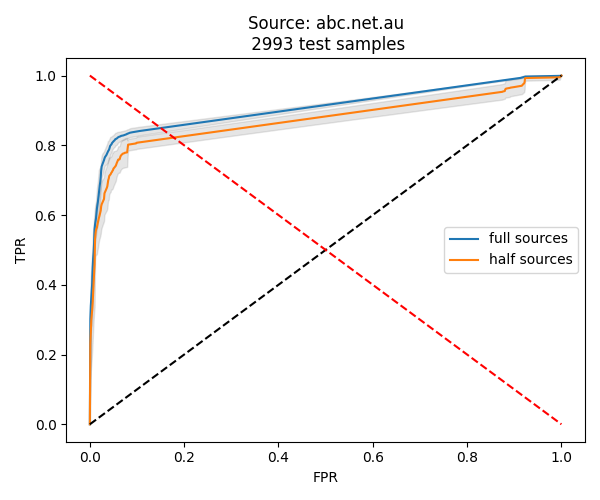

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
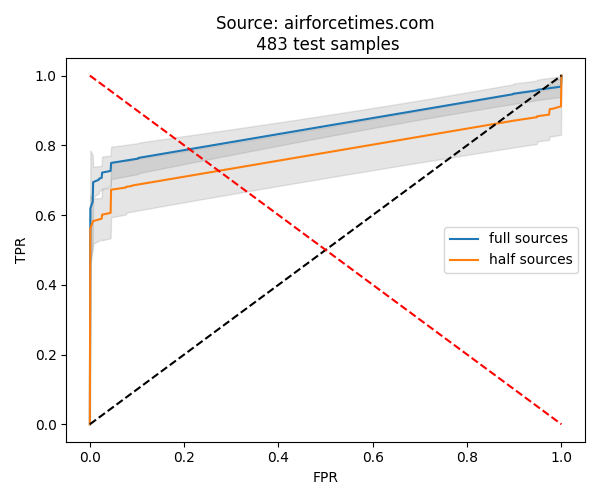

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
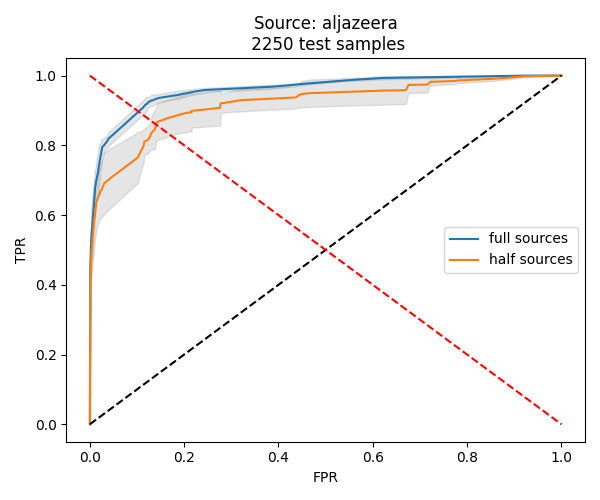

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
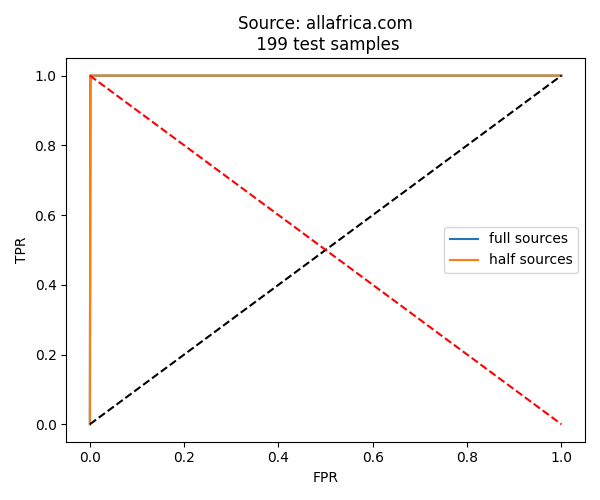

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
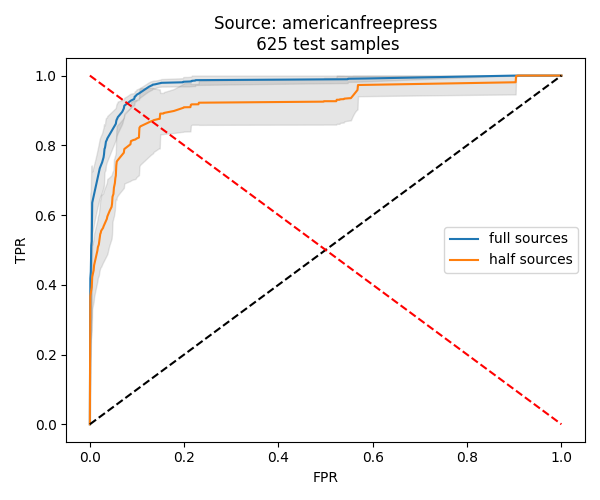

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
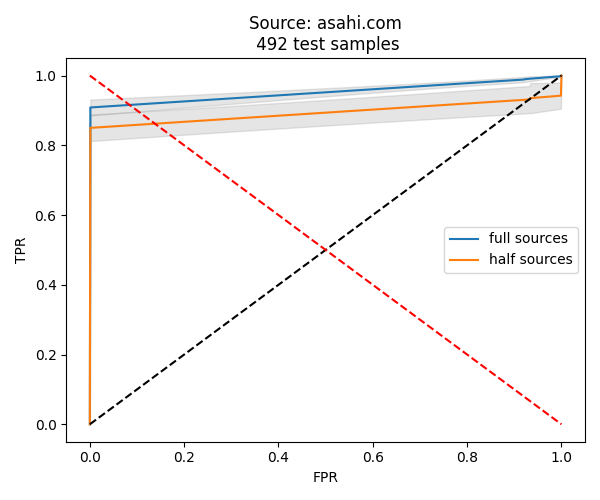

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
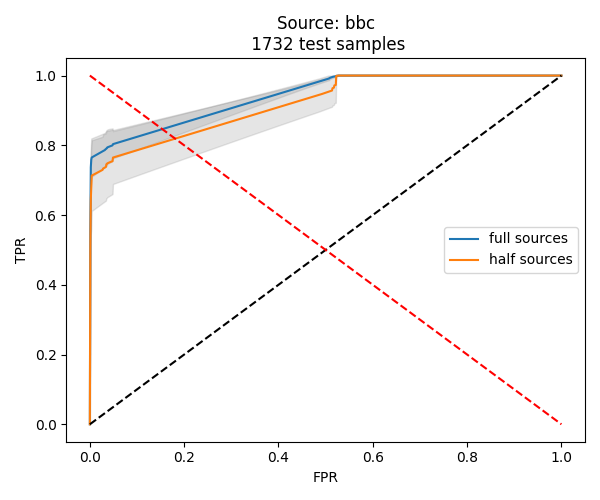

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
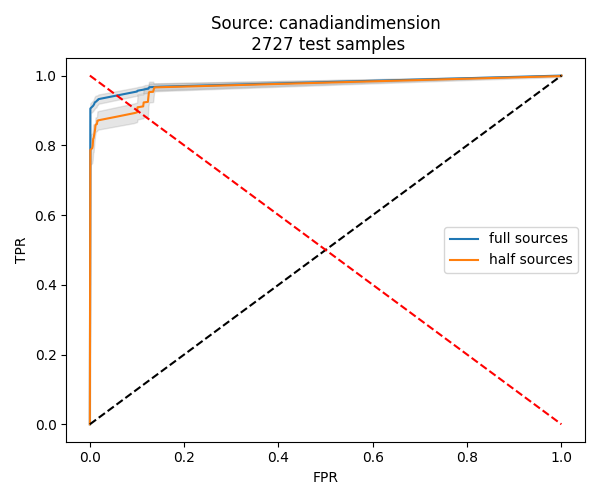

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
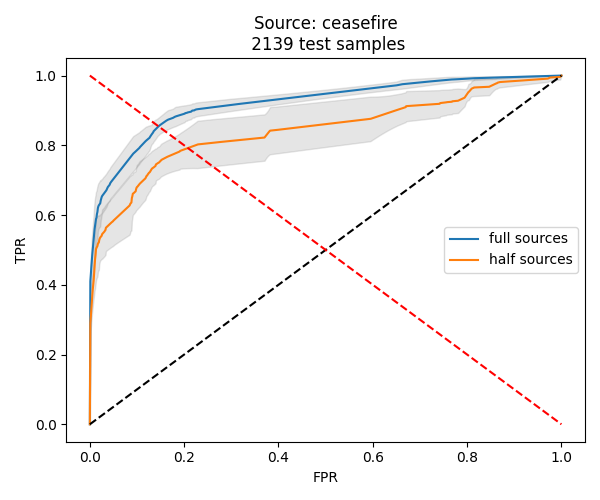

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
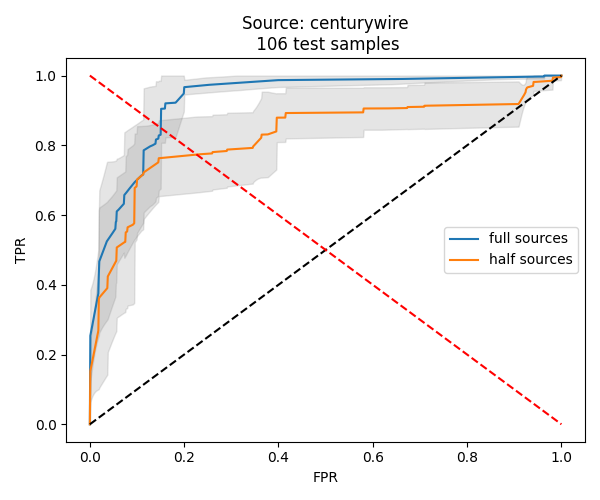

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
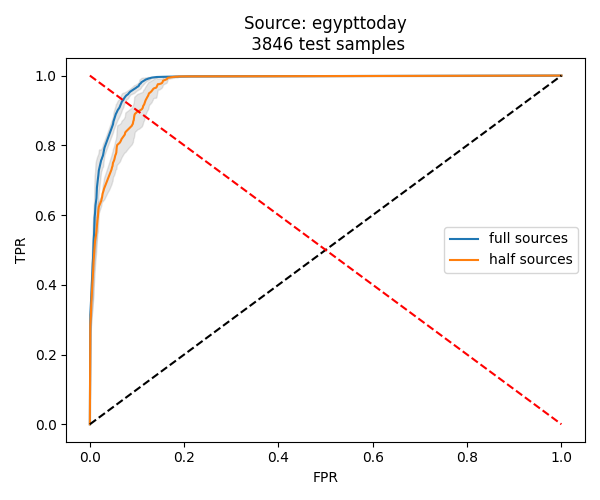

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
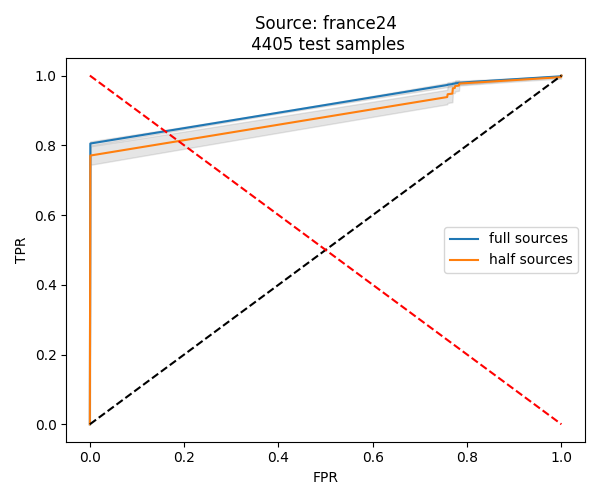

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
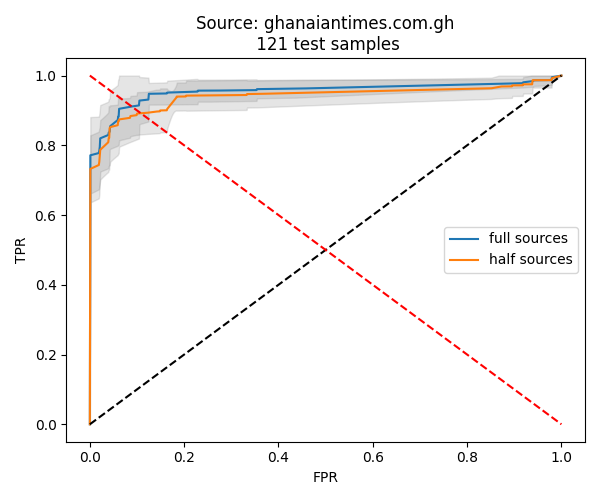

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
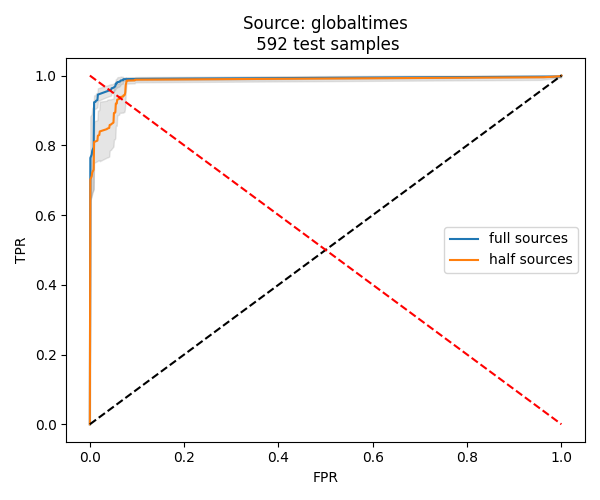

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
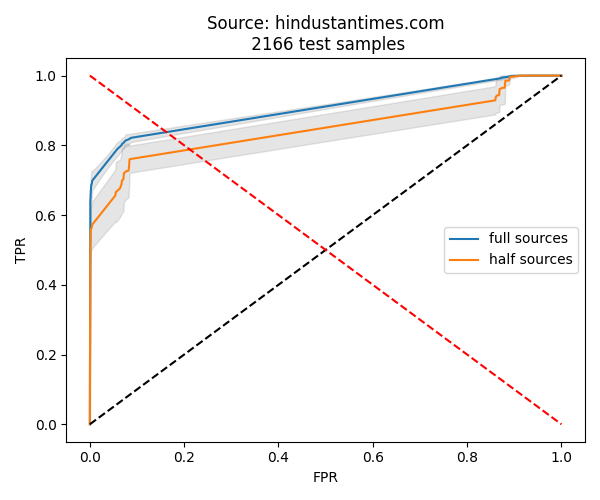

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
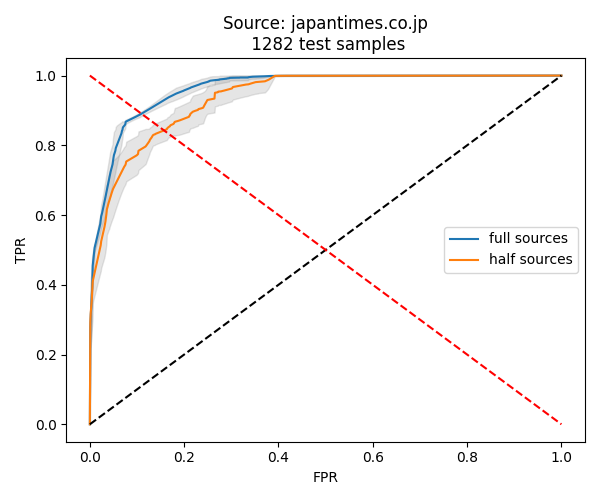

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
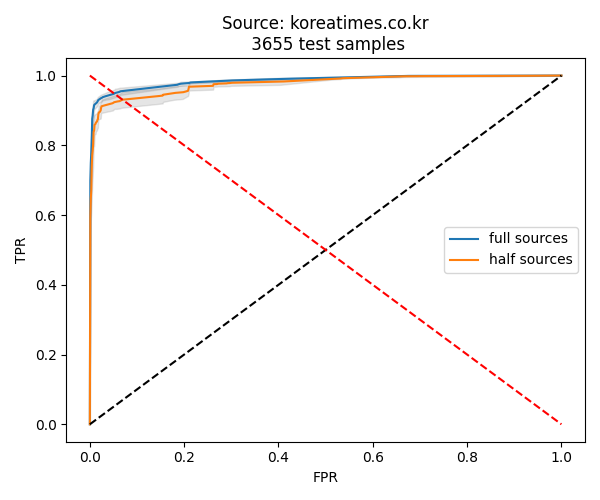

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
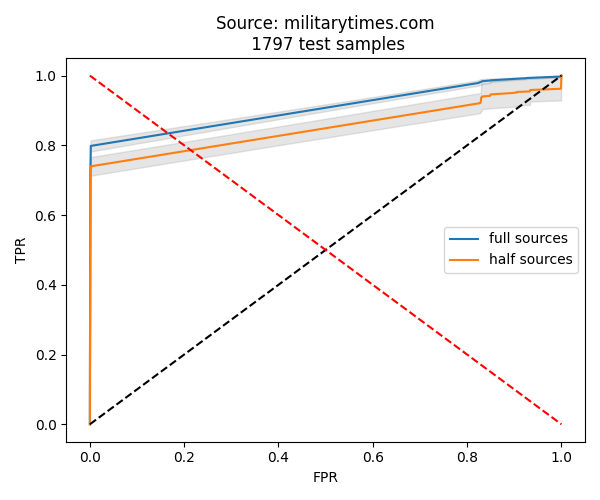

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
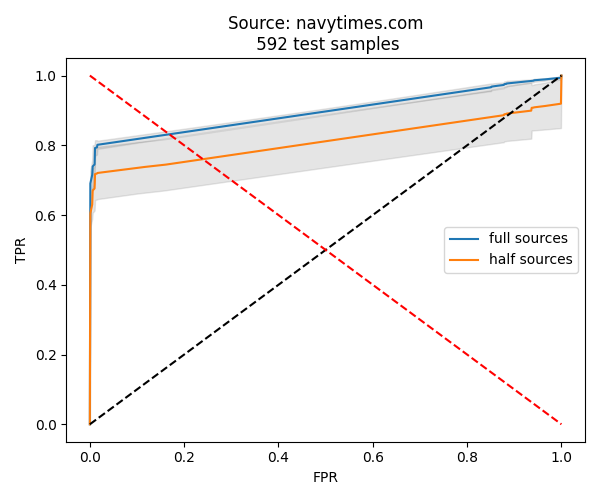

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
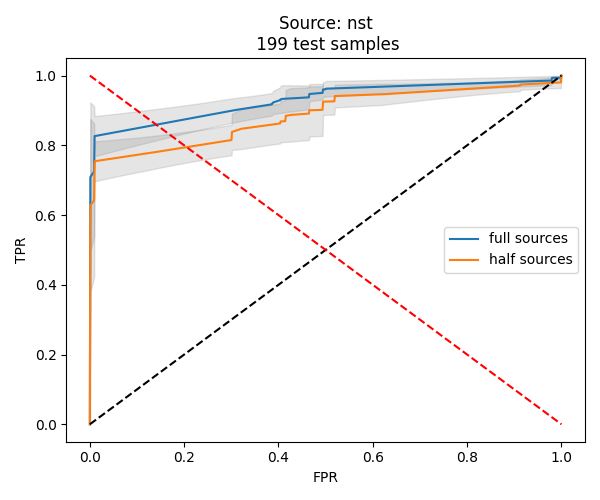

/tmp/ipykernel_823/41228628.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(6,5))


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
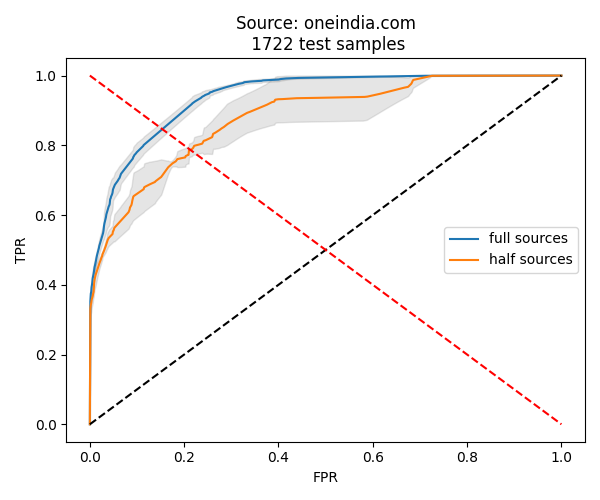

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
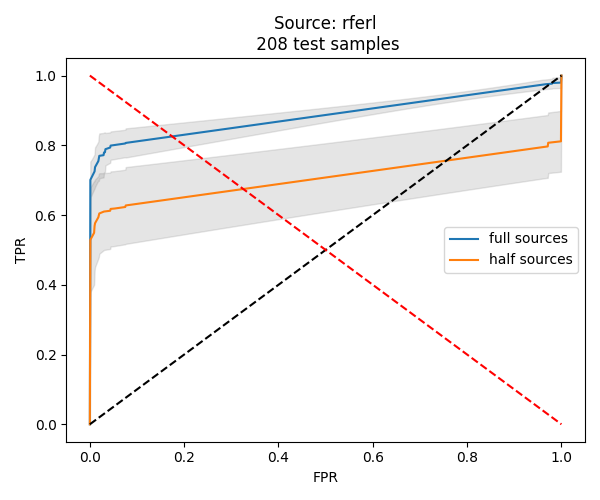

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
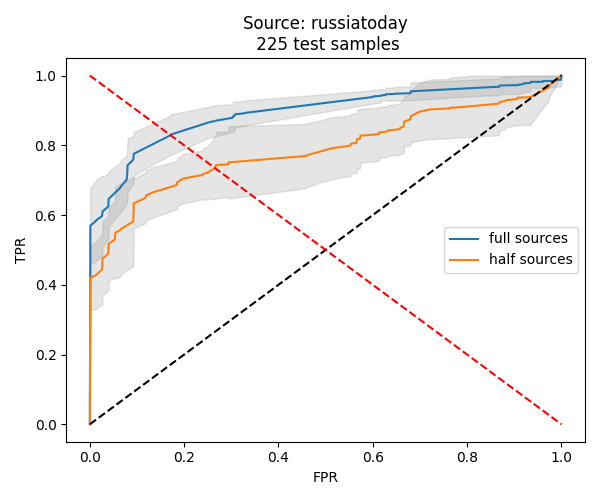

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
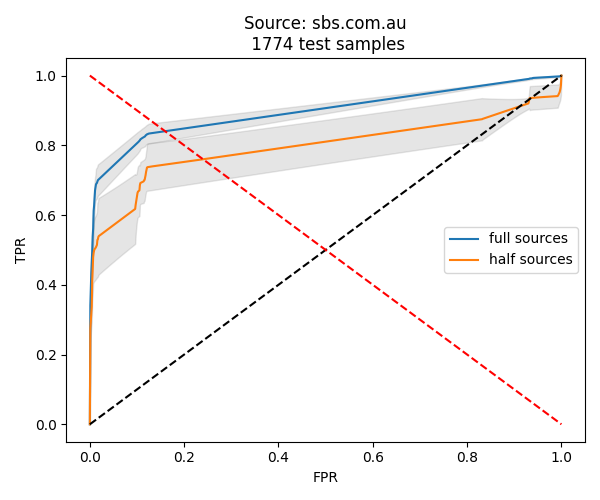

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
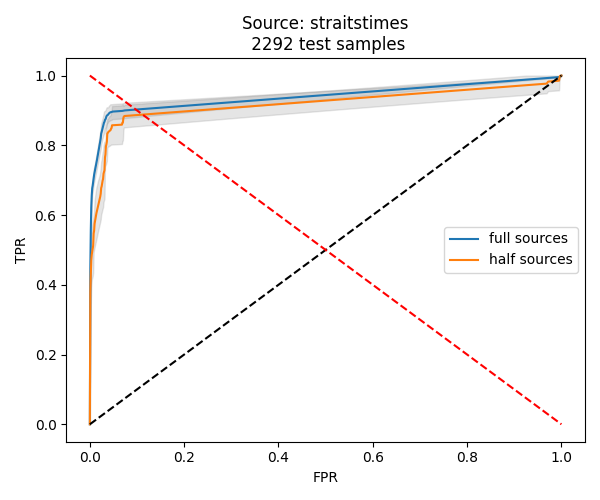

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
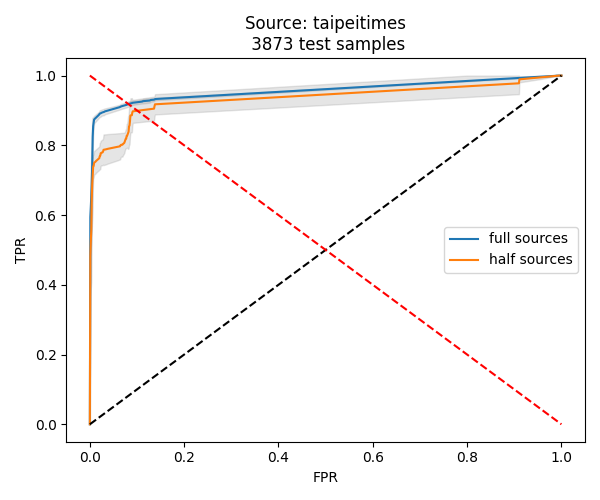

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
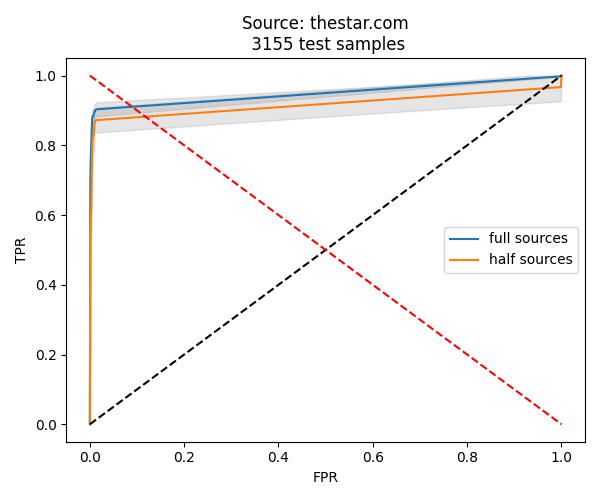

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
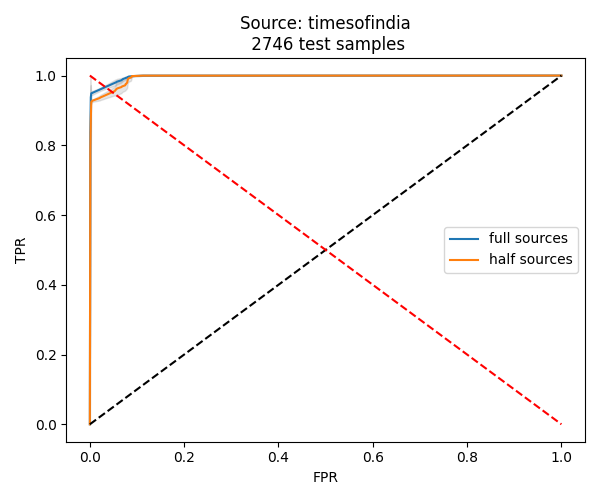

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
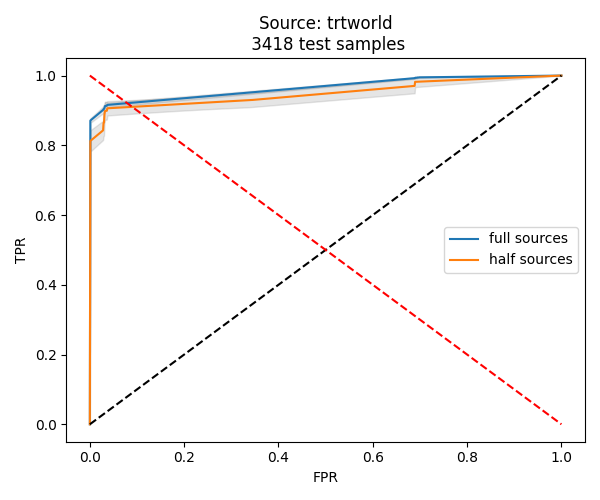

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
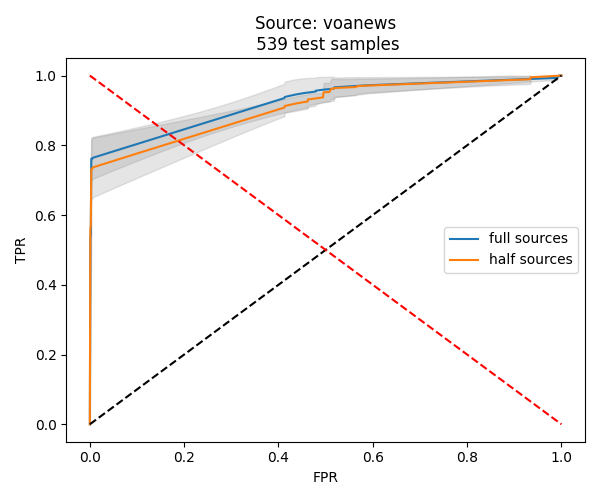

In [19]:
EERs_mean_qm_big = []
EERs_mean_qm_small = []

#------------
#New-EER
EERs_all_qm_big = []
EERs_all_qm_small = []
EERs_std_qm_big = []
EERs_std_qm_small = []
#------------

for source in sources:
  plt.figure(figsize=(6,5))

  interp_fpr = np.linspace(0, 1, 1000)
  
  #-----------------------------------------------
  
  #New-EER
  EERs_per_src_qm_big = []
  
  interp_tprs_qm_big = []
  #interpolate between fpr,tpr datapoints to compute tpr at regular fpr intervals
  for trial in range(NUM_TRIALS):
    fpr = results_per_trial_qm_big[trial][source]['fpr']
    tpr = results_per_trial_qm_big[trial][source]['tpr']
    interp_tpr = np.interp(interp_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    interp_tprs_qm_big.append(interp_tpr)
    #------------
    #New-EER
    EERs_per_src_qm_big.append(calculate_eer(interp_fpr, interp_tpr)) #get EERs across all trials for this source
  EERs_std_qm_big.append( np.std(EERs_per_src_qm_big) ) #gives a std of EER for each source, across all 5 trials
  EERs_all_qm_big.append(EERs_per_src_qm_big) #all data: first index gives src, second index gives trial
  #------------

  mean_tpr_qm_big = np.mean(interp_tprs_qm_big, axis=0)
  mean_tpr_qm_big[-1] = 1.0
  
  EERs_mean_qm_big.append(calculate_eer(interp_fpr, mean_tpr_qm_big))
  
  std_tpr_qm_big = np.std(interp_tprs_qm_big, axis=0)
  tprs_upper_qm_big = np.minimum(mean_tpr_qm_big + std_tpr_qm_big, 1)
  tprs_lower_qm_big = np.maximum(mean_tpr_qm_big - std_tpr_qm_big, 0)
  plt.plot(interp_fpr, mean_tpr_qm_big,  linestyle="-", label="full sources")
  plt.fill_between(interp_fpr, tprs_lower_qm_big, tprs_upper_qm_big, color='grey', alpha=.2)

  auc_mean_qm_big = float(df_summary.loc[df_summary['source']==source, 'AUC_mean_qm_big'])
  auc_std_qm_big = float(df_summary.loc[ df_summary['source']==source, 'AUC_std_qm_big'])
  tpr_at_fpr_mean_qm_big = float(df_summary.loc[ df_summary['source']==source, 'tpr_at_fpr_mean_qm_big'])
  numsamples = int(df_summary.loc[ df_summary['source']==source, 'test_size'])

  #-----------------------------------------------
  
  #New-EER
  EERs_per_src_qm_small = []
  
  interp_tprs_qm_small = []
  #interpolate between fpr,tpr datapoints to compute tpr at regular fpr intervals
  for trial in range(NUM_TRIALS):
    fpr = results_per_trial_qm_small[trial][source]['fpr']
    tpr = results_per_trial_qm_small[trial][source]['tpr']
    interp_tpr = np.interp(interp_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    interp_tprs_qm_small.append(interp_tpr)
  #------------
    #New-EER
    EERs_per_src_qm_small.append(calculate_eer(interp_fpr, interp_tpr)) #get EERs across all trials for this source
  EERs_std_qm_small.append( np.std(EERs_per_src_qm_small) ) #gives a std of EER for each source, across all 5 trials
  EERs_all_qm_small.append(EERs_per_src_qm_small) #all data: first index gives src, second index gives trial
  #------------

  mean_tpr_qm_small = np.mean(interp_tprs_qm_small, axis=0)
  mean_tpr_qm_small[-1] = 1.0
  
  EERs_mean_qm_small.append(calculate_eer(interp_fpr, mean_tpr_qm_small))

  std_tpr_qm_small = np.std(interp_tprs_qm_small, axis=0)
  tprs_upper_qm_small = np.minimum(mean_tpr_qm_small + std_tpr_qm_small, 1)
  tprs_lower_qm_small = np.maximum(mean_tpr_qm_small - std_tpr_qm_small, 0)
  plt.plot(interp_fpr, mean_tpr_qm_small,  linestyle="-", label="half sources")
  plt.fill_between(interp_fpr, tprs_lower_qm_small, tprs_upper_qm_small, color='grey', alpha=.2)

  auc_mean_qm_small = float(df_summary.loc[df_summary['source']==source, 'AUC_mean_qm_small'])
  auc_std_qm_small = float(df_summary.loc[ df_summary['source']==source, 'AUC_std_qm_small'])
  tpr_at_fpr_mean_qm_small = float(df_summary.loc[ df_summary['source']==source, 'tpr_at_fpr_mean_qm_small'])
  #-----------------------------------------------
  
  plt.plot([0, 1], [0, 1], color="black", linestyle="--")
  plt.plot(np.linspace(0,1,100), 1-np.linspace(0,1,100), color="red", linestyle="--")
  plt.title('Source: {}\n {} test samples'.format(
    source, numsamples))
  plt.xlabel("FPR")
  plt.ylabel("TPR")
  plt.legend()
  plt.tight_layout() 
  plt.show()
  plt.savefig(os.path.join(RESULTS_FOLDER, "roc_{}.pdf".format(source)), bbox_inches='tight')
  
df_summary['EER_mean_qm_small'] = EERs_mean_qm_small
df_summary['EER_mean_qm_big'] = EERs_mean_qm_big
df_summary['EER_mean_diff'] = df_summary['EER_mean_qm_big'] - df_summary['EER_mean_qm_small']

#New-EER
df_summary['EER_std_qm_big'] = EERs_std_qm_big
df_summary['EER_std_qm_small'] = EERs_std_qm_small

In [20]:
df_summary['AUC_formatted_small'] = uncertainty_format_arrays(df_summary['AUC_mean_qm_small'], df_summary['AUC_std_qm_small'])
df_summary['AUC_formatted_big'] = uncertainty_format_arrays(df_summary['AUC_mean_qm_big'], df_summary['AUC_std_qm_big'])

In [21]:
df_summary

,source,test_size,AUC_mean_qm_small,AUC_std_qm_small,tpr_at_fpr_mean_qm_small,AUC_mean_qm_big,AUC_std_qm_big,tpr_at_fpr_mean_qm_big,AUC_mean_diff,tpr_at_fpr_mean_diff,EER_mean_qm_small,EER_mean_qm_big,EER_mean_diff,EER_std_qm_big,EER_std_qm_small,AUC_formatted_small,AUC_formatted_big
0,abc.net.au,2993,0.873439,0.015371,0.328529,0.906758,0.006166,0.404668,0.033319,0.076139,0.177855,0.150488,-0.027367,0.009606,0.014986,0.87(2),0.907(6)
1,airforcetimes.com,483,0.775910,0.071490,0.575630,0.853172,0.031332,0.634262,0.077262,0.058633,0.273143,0.211192,-0.061951,0.031491,0.060299,0.78(7),0.85(3)
2,aljazeera,2250,0.920964,0.027538,0.520456,0.960384,0.004974,0.566963,0.039420,0.046506,0.140572,0.103458,-0.037114,0.009274,0.032479,0.92(3),0.960(5)
3,allafrica.com,199,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.001000,0.001000,0.000000,0.000000,0.000000,1.0(0),1.0(0)
4,americanfreepress,625,0.918321,0.046355,0.422749,0.973354,0.009302,0.635278,0.055033,0.212529,0.130664,0.079544,-0.051120,0.012191,0.045258,0.92(5),0.973(9)
5,asahi.com,492,0.893809,0.036848,0.850351,0.952151,0.011793,0.908862,0.058341,0.058511,0.138051,0.084232,-0.053819,0.018594,0.034323,0.89(4),0.95(1)
6,bbc,1732,0.921283,0.032576,0.713899,0.941945,0.012092,0.765904,0.020662,0.052004,0.180951,0.153655,-0.027296,0.022371,0.045839,0.92(3),0.94(1)
7,canadiandimension,2727,0.969378,0.004415,0.791654,0.978511,0.005964,0.910745,0.009133,0.119090,0.100446,0.057176,-0.043270,0.009933,0.016333,0.969(4),0.979(6)
8,ceasefire,2139,0.844650,0.041406,0.365932,0.920938,0.014286,0.484399,0.076288,0.118468,0.207794,0.145704,-0.062090,0.012935,0.040356,0.84(4),0.92(1)
9,centurywire,106,0.827150,0.045514,0.179693,0.929908,0.026338,0.282408,0.102758,0.102716,0.226339,0.150410,-0.075929,0.039911,0.087445,0.83(5),0.93(3)


In [22]:
print(len(df_train_small['source'].unique()))

df_train_small['source'].unique()

15


array(['airforcetimes.com', 'allafrica.com', 'asahi.com', 'bbc',
       'centurywire', 'france24', 'japantimes.co.jp', 'koreatimes.co.kr',
       'rferl', 'russiatoday', 'sbs.com.au', 'straitstimes',
       'taipeitimes', 'timesofindia', 'voanews'], dtype=object)

In [23]:
print(len(df_train_big['source'].unique()))

df_train_big['source'].unique()

30


array(['abc.net.au', 'airforcetimes.com', 'aljazeera', 'allafrica.com',
       'americanfreepress', 'asahi.com', 'bbc', 'canadiandimension',
       'ceasefire', 'centurywire', 'egypttoday', 'france24',
       'ghanaiantimes.com.gh', 'globaltimes', 'hindustantimes.com',
       'japantimes.co.jp', 'koreatimes.co.kr', 'militarytimes.com',
       'navytimes.com', 'nst', 'oneindia.com', 'rferl', 'russiatoday',
       'sbs.com.au', 'straitstimes', 'taipeitimes', 'thestar.com',
       'timesofindia', 'trtworld', 'voanews'], dtype=object)

In [24]:
df_summary

,source,test_size,AUC_mean_qm_small,AUC_std_qm_small,tpr_at_fpr_mean_qm_small,AUC_mean_qm_big,AUC_std_qm_big,tpr_at_fpr_mean_qm_big,AUC_mean_diff,tpr_at_fpr_mean_diff,EER_mean_qm_small,EER_mean_qm_big,EER_mean_diff,EER_std_qm_big,EER_std_qm_small,AUC_formatted_small,AUC_formatted_big
0,abc.net.au,2993,0.873439,0.015371,0.328529,0.906758,0.006166,0.404668,0.033319,0.076139,0.177855,0.150488,-0.027367,0.009606,0.014986,0.87(2),0.907(6)
1,airforcetimes.com,483,0.775910,0.071490,0.575630,0.853172,0.031332,0.634262,0.077262,0.058633,0.273143,0.211192,-0.061951,0.031491,0.060299,0.78(7),0.85(3)
2,aljazeera,2250,0.920964,0.027538,0.520456,0.960384,0.004974,0.566963,0.039420,0.046506,0.140572,0.103458,-0.037114,0.009274,0.032479,0.92(3),0.960(5)
3,allafrica.com,199,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.001000,0.001000,0.000000,0.000000,0.000000,1.0(0),1.0(0)
4,americanfreepress,625,0.918321,0.046355,0.422749,0.973354,0.009302,0.635278,0.055033,0.212529,0.130664,0.079544,-0.051120,0.012191,0.045258,0.92(5),0.973(9)
5,asahi.com,492,0.893809,0.036848,0.850351,0.952151,0.011793,0.908862,0.058341,0.058511,0.138051,0.084232,-0.053819,0.018594,0.034323,0.89(4),0.95(1)
6,bbc,1732,0.921283,0.032576,0.713899,0.941945,0.012092,0.765904,0.020662,0.052004,0.180951,0.153655,-0.027296,0.022371,0.045839,0.92(3),0.94(1)
7,canadiandimension,2727,0.969378,0.004415,0.791654,0.978511,0.005964,0.910745,0.009133,0.119090,0.100446,0.057176,-0.043270,0.009933,0.016333,0.969(4),0.979(6)
8,ceasefire,2139,0.844650,0.041406,0.365932,0.920938,0.014286,0.484399,0.076288,0.118468,0.207794,0.145704,-0.062090,0.012935,0.040356,0.84(4),0.92(1)
9,centurywire,106,0.827150,0.045514,0.179693,0.929908,0.026338,0.282408,0.102758,0.102716,0.226339,0.150410,-0.075929,0.039911,0.087445,0.83(5),0.93(3)


In [25]:
df_latex = df_summary[['source', 'test_size', 'AUC_formatted_big', 'AUC_formatted_small', 'tpr_at_fpr_mean_qm_big', 'tpr_at_fpr_mean_qm_small', 'EER_mean_qm_big','EER_mean_qm_small']]
df_latex.columns=['source', 'test size', 'AUC (full)', 'AUC (half)', 'tpr@fpr (full)', 'tpr@fpr (half)', 'EER (full)','EER (half)']
df_latex

,source,test size,AUC (full),AUC (half),tpr@fpr (full),tpr@fpr (half),EER (full),EER (half)
0,abc.net.au,2993,0.907(6),0.87(2),0.404668,0.328529,0.150488,0.177855
1,airforcetimes.com,483,0.85(3),0.78(7),0.634262,0.575630,0.211192,0.273143
2,aljazeera,2250,0.960(5),0.92(3),0.566963,0.520456,0.103458,0.140572
3,allafrica.com,199,1.0(0),1.0(0),1.000000,1.000000,0.001000,0.001000
4,americanfreepress,625,0.973(9),0.92(5),0.635278,0.422749,0.079544,0.130664
5,asahi.com,492,0.95(1),0.89(4),0.908862,0.850351,0.084232,0.138051
6,bbc,1732,0.94(1),0.92(3),0.765904,0.713899,0.153655,0.180951
7,canadiandimension,2727,0.979(6),0.969(4),0.910745,0.791654,0.057176,0.100446
8,ceasefire,2139,0.92(1),0.84(4),0.484399,0.365932,0.145704,0.207794
9,centurywire,106,0.93(3),0.83(5),0.282408,0.179693,0.150410,0.226339


In [26]:
# 3 sig figs use '%.3g'; 3 digits use '%.3f'
latex_table = df_latex.to_latex(index=False, float_format='%.3g')
with open(os.path.join(RESULTS_FOLDER,"table1.tex"),"w") as file1:
  file1.write(latex_table)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
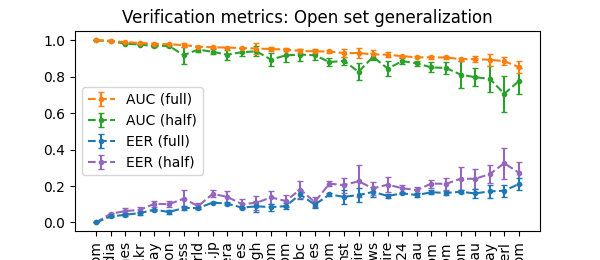

In [27]:
df_metricplot =  df_summary.sort_values(by='AUC_mean_qm_big', ascending=False).reset_index(drop=True)
sources_metricplot = list(df_metricplot['source'])


# plt.figure(figsize=(6,3.5))
plt.figure(figsize=(6, 2.6))
x_vals = [i for i,_ in enumerate(sources_metricplot)]


#plt.plot(x_vals, df_metricplot['EER_mean_qm_small'], linestyle='--', marker='.', label="EER (half)", color="tab:purple")
plt.errorbar(x_vals, df_metricplot['EER_mean_qm_small'], yerr=df_metricplot['EER_std_qm_small'],
             fmt=".", linestyle="--", label="EER (half)", color="tab:purple",
             mfc="tab:purple", mec='tab:purple', ecolor="tab:purple", capsize=2)

#plt.plot(x_vals, df_metricplot['EER_mean_qm_big'], linestyle='--', marker='.', label="EER (full)", color="tab:blue")
plt.errorbar(x_vals, df_metricplot['EER_mean_qm_big'], yerr=df_metricplot['EER_std_qm_big'],
             linestyle='--', marker='.', label="EER (full)", color="tab:blue",
             mfc="tab:blue", mec='tab:blue', ecolor="tab:blue", capsize=2)

plt.errorbar(x_vals, df_metricplot['AUC_mean_qm_small'], yerr=df_metricplot['AUC_std_qm_small'], 
             fmt=".", linestyle="--", label="AUC (half)", color="tab:green", 
             mfc="tab:green", mec='tab:green', ecolor="tab:green", capsize=2)

plt.errorbar(x_vals, df_metricplot['AUC_mean_qm_big'], yerr=df_metricplot['AUC_std_qm_big'], 
             fmt=".", linestyle="--", label="AUC (full)", color="tab:orange", 
             mfc="tab:orange", mec='tab:orange', ecolor="tab:orange", capsize=2)


plt.xticks(x_vals, sources_metricplot, rotation=90)

handles, labels = plt.gca().get_legend_handles_labels()
handles = [handles[3], handles[2], handles[1], handles[0]]
labels = [labels[3], labels[2], labels[1], labels[0]]
plt.legend(handles, labels, loc="center left")

plt.title("Verification metrics: Open set generalization")

# plt.tight_layout()
plt.yticks(np.arange(0.0, 1.2, 0.2))
plt.show()
# #uncomment to save:
plt.savefig(os.path.join(RESULTS_FOLDER,"verification_metrics_plot.pdf"), bbox_inches='tight')

In [28]:
df_summary

,source,test_size,AUC_mean_qm_small,AUC_std_qm_small,tpr_at_fpr_mean_qm_small,AUC_mean_qm_big,AUC_std_qm_big,tpr_at_fpr_mean_qm_big,AUC_mean_diff,tpr_at_fpr_mean_diff,EER_mean_qm_small,EER_mean_qm_big,EER_mean_diff,EER_std_qm_big,EER_std_qm_small,AUC_formatted_small,AUC_formatted_big
0,abc.net.au,2993,0.873439,0.015371,0.328529,0.906758,0.006166,0.404668,0.033319,0.076139,0.177855,0.150488,-0.027367,0.009606,0.014986,0.87(2),0.907(6)
1,airforcetimes.com,483,0.775910,0.071490,0.575630,0.853172,0.031332,0.634262,0.077262,0.058633,0.273143,0.211192,-0.061951,0.031491,0.060299,0.78(7),0.85(3)
2,aljazeera,2250,0.920964,0.027538,0.520456,0.960384,0.004974,0.566963,0.039420,0.046506,0.140572,0.103458,-0.037114,0.009274,0.032479,0.92(3),0.960(5)
3,allafrica.com,199,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.001000,0.001000,0.000000,0.000000,0.000000,1.0(0),1.0(0)
4,americanfreepress,625,0.918321,0.046355,0.422749,0.973354,0.009302,0.635278,0.055033,0.212529,0.130664,0.079544,-0.051120,0.012191,0.045258,0.92(5),0.973(9)
5,asahi.com,492,0.893809,0.036848,0.850351,0.952151,0.011793,0.908862,0.058341,0.058511,0.138051,0.084232,-0.053819,0.018594,0.034323,0.89(4),0.95(1)
6,bbc,1732,0.921283,0.032576,0.713899,0.941945,0.012092,0.765904,0.020662,0.052004,0.180951,0.153655,-0.027296,0.022371,0.045839,0.92(3),0.94(1)
7,canadiandimension,2727,0.969378,0.004415,0.791654,0.978511,0.005964,0.910745,0.009133,0.119090,0.100446,0.057176,-0.043270,0.009933,0.016333,0.969(4),0.979(6)
8,ceasefire,2139,0.844650,0.041406,0.365932,0.920938,0.014286,0.484399,0.076288,0.118468,0.207794,0.145704,-0.062090,0.012935,0.040356,0.84(4),0.92(1)
9,centurywire,106,0.827150,0.045514,0.179693,0.929908,0.026338,0.282408,0.102758,0.102716,0.226339,0.150410,-0.075929,0.039911,0.087445,0.83(5),0.93(3)
